In [1]:
import pandas as pd
import numpy as np

def create_timeseries_for_symbol(df, symbol_id):
    """
    Create feature and responder time series for a given symbol
    
    Args:
        df: Input dataframe
        symbol_id: Symbol to process
    
    Returns:
        tuple: (feature_series, responder_series)
    """
    # Sort by date_id and time_id, then filter for our symbol
    df_sorted = df.sort_values(['date_id', 'time_id'])
    symbol_data = df_sorted[df_sorted['symbol_id'] == symbol_id].copy()
    
    # Get column names
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    responder_cols = [col for col in df.columns if col.startswith('responder_') and col != 'responder_6']
    
    # Get first date and its last time for responders
    first_date = symbol_data['date_id'].min()
    first_date_last_time = symbol_data[symbol_data['date_id'] == first_date]['time_id'].max()
    first_date_last_responders = symbol_data[
        (symbol_data['date_id'] == first_date) & 
        (symbol_data['time_id'] == first_date_last_time)
    ][responder_cols]
    
    # Get all data after first date (for features)
    feature_series = symbol_data[symbol_data['date_id'] > first_date][feature_cols].copy()
    
    # Get all data after first date except the last row (for responders)
    responder_data = symbol_data[symbol_data['date_id'] > first_date][responder_cols].iloc[:-1]
    
    # Add first date's last responders at the start
    responder_series = pd.concat([first_date_last_responders, responder_data])
    
    return feature_series, responder_series

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders = create_timeseries_for_symbol(df, symbol_id)
    
    # Print verification
    print(f"Feature series shape: {features.shape}")
    print("\nFirst few rows of feature series:")
    print(features.head())
    print(f"Responder series shape: {responders.shape}")
    print("\nFirst few rows of responder series (should start with final time_id of first date):")
    print(responders.head())

Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      feat

In [3]:
import pandas as pd
import numpy as np

# Load data
features_df = pd.read_csv('features.csv')

# Look at first few features that show NaN in your time series
nan_features = ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_73', 'feature_74']

# Extract tag patterns for these features
nan_patterns = features_df[features_df['feature'].isin(nan_features)]
print("Tag patterns for features that show NaN values:")
print(nan_patterns)

# Count True values for each tag column in NaN features
print("\nCount of True values for each tag in NaN features:")
true_counts = nan_patterns.iloc[:, 1:].sum()
print(true_counts[true_counts > 0])  # Only show tags that are True for any of these features

# Also look at some features that don't have NaN
non_nan_features = ['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09']
non_nan_patterns = features_df[features_df['feature'].isin(non_nan_features)]
print("\nTag patterns for features that don't show NaN values:")
print(non_nan_patterns)

Tag patterns for features that show NaN values:
       feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0   feature_00  False  False   True  False  False  False  False  False  False   
1   feature_01  False  False   True  False  False  False  False  False  False   
2   feature_02  False  False   True  False  False  False  False  False  False   
3   feature_03  False  False   True  False  False  False  False  False  False   
4   feature_04  False  False   True  False  False  False  False  False  False   
73  feature_73  False  False  False  False  False  False  False  False   True   
74  feature_74  False  False  False  False  False  False  False  False   True   

    tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0   False   False   False   False   False    True   False    True  
1   False   False   False   False    True    True   False    True  
2   False   False   False    True   False   False   False    True  
3   False   False   False   Fal

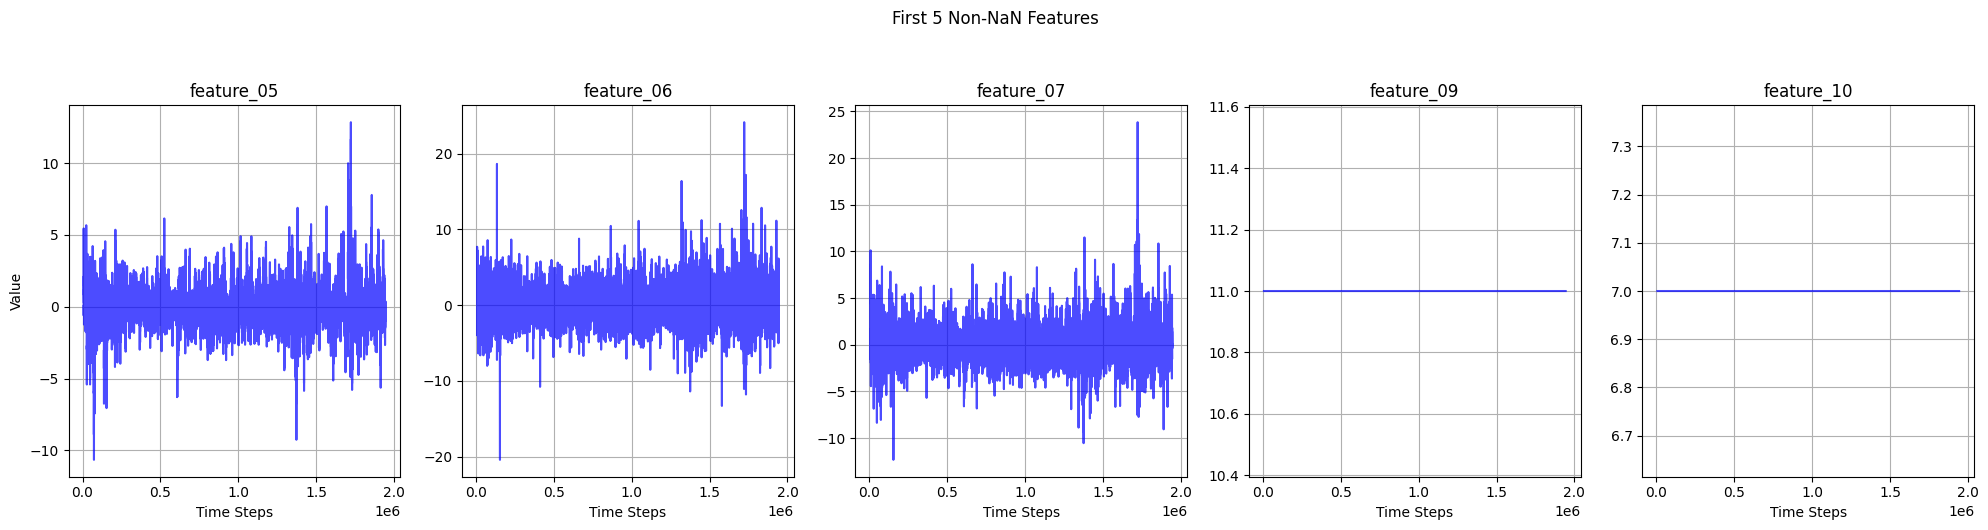

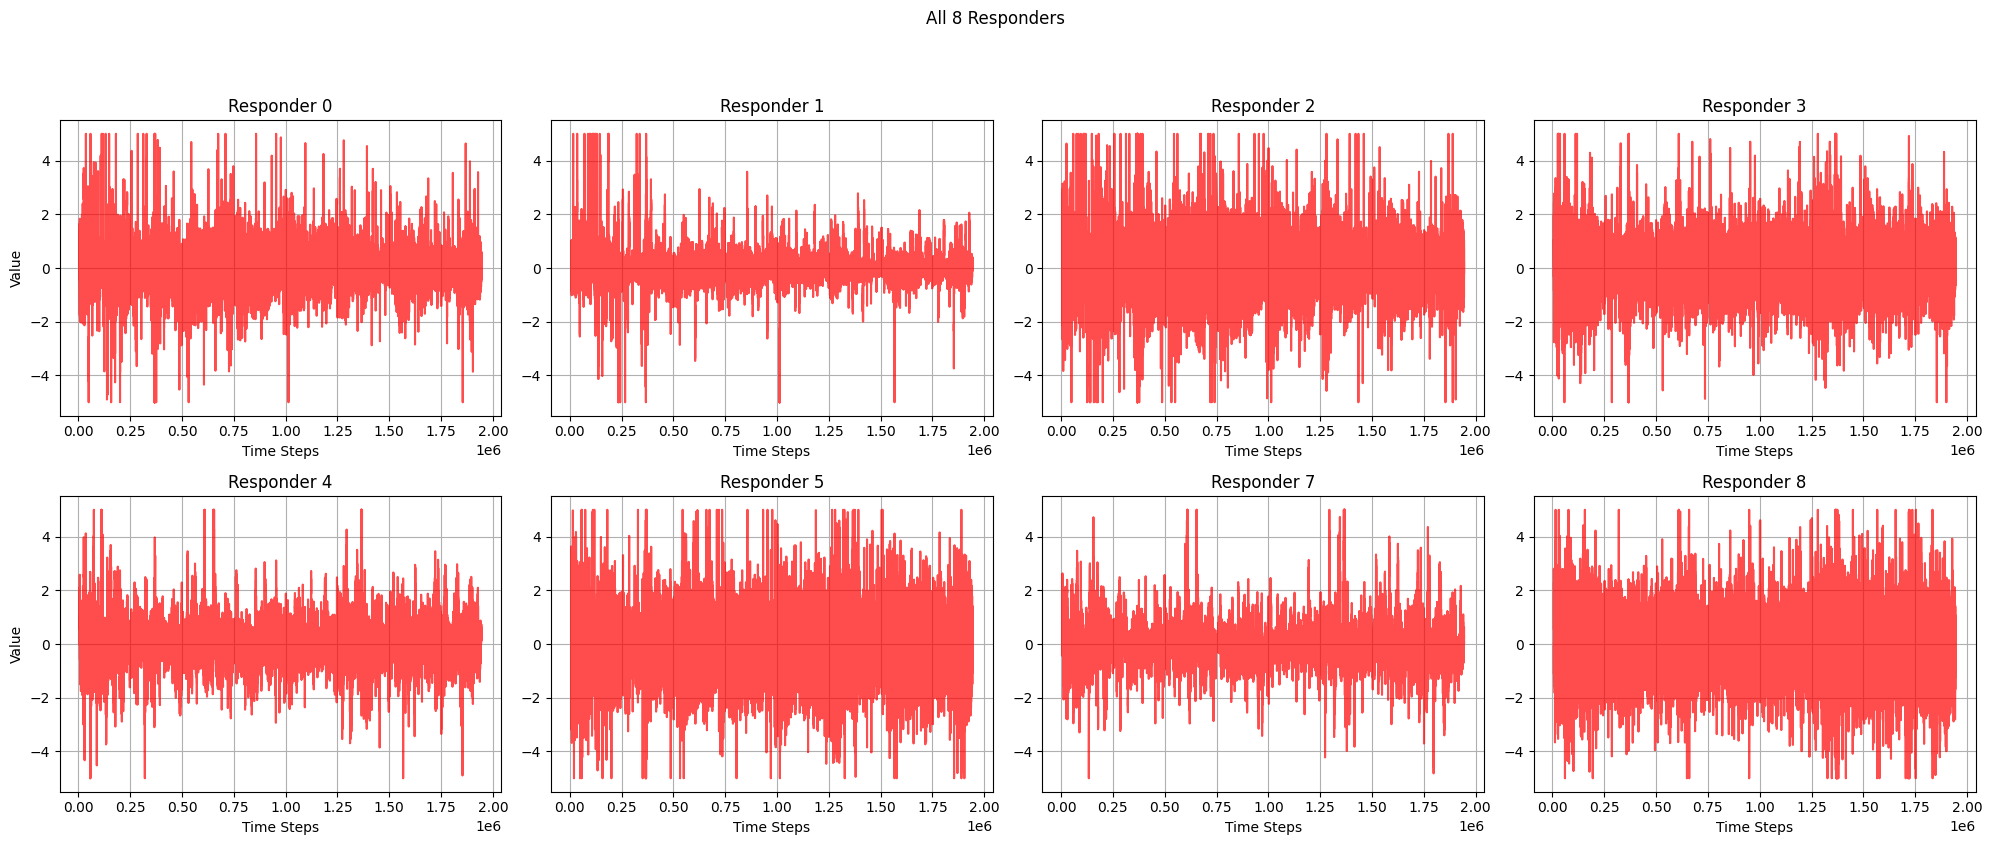

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_separate_timeseries(features, responders):
    """
    Create separate subplots for first 5 features and all 8 responders
    """
    plt.figure(figsize=(20, 5))
    clean_features_plotted = 0
    all_features = features.columns
    
    # Keep plotting until we get 5 clean features
    for feature_name in all_features:
        # Check if this feature has any NaN
        if not features[feature_name].isna().any():
            ax = plt.subplot(1, 5, clean_features_plotted + 1)
            timeseries = features[feature_name]
            ax.plot(timeseries, color='blue', alpha=0.7)
            ax.set_title(feature_name)
            ax.grid(True)
            if clean_features_plotted == 0:
                ax.set_ylabel('Value')
            ax.set_xlabel('Time Steps')
            
            clean_features_plotted += 1
            if clean_features_plotted == 5:  # Stop after 5 clean features
                break
    
    plt.suptitle('First 5 Non-NaN Features', y=1.05)
    plt.tight_layout()
    plt.show()

    # Second plot - Responders
    plt.figure(figsize=(20, 8))
    for i, col in enumerate(responders.columns):
        ax = plt.subplot(2, 4, i+1)  # 2 rows, 4 columns
        ax.plot(responders[col], color='red', alpha=0.7)
        ax.set_title(f'Responder {col[-1]}')
        ax.grid(True)
        if i % 4 == 0:  # Add y-label for leftmost plots
            ax.set_ylabel('Value')
        ax.set_xlabel('Time Steps')
    plt.suptitle('All 8 Responders', y=1.05)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders = create_timeseries_for_symbol(df, symbol_id)
    
    # Plot
    plot_separate_timeseries(features, responders)